In [185]:
import numpy as np
from time_integrators import RK2, RK4, theta_scheme
from scipy.optimize import root
import pylab as pl
%matplotlib inline

pl.style.use('latexplot')

In [186]:
# Defining the x-domain:
x_start = 0
x_end   = 40
N_x     = 401
dx      = (x_end - x_start) / N_x

# Number of ghost cells:
N_g     = 1
x       = x_start + (0.5 + np.arange(-N_g, N_x + N_g)) * dx

In [187]:
# Defining the time array:
t_final = 20
N_t     = 20001
t       = np.linspace(0, t_final, N_t)
dt      = t[1] - t[0]

In [200]:
# Defining the dimensionless concentration of species A:
a0 = x**0

# The applied potential is going to be varied as E(t) = E_start + t
# Below, we are defining E_start (starting potential) (dicated by experimenter):
E_start = -10
# Formal potential (dictated by chemical)
E0 = -1
# Rate constant of the reaction:
k0 = 100
# Charge transfer coefficient:
alpha = 0.5

# Time period for cyclic voltametry:
t_rev = 20

# Parameters for AC
delta_E = 8
omega   = 4 * np.pi

In [201]:
# Applied potential for linear voltametry:
def E_linear(t):
    return(E_start + t)
# Applied potential for cyclic voltametry:
def E_cyclic(t):
    if((t % (2 * t_rev)) <= t_rev):
        return(E_start + t)
    else:
        return(E_start + 2 * t_rev - (t % (2 * t_rev)))
def E_swm(t):
    return(E_linear(t) + delta_E * (-1)**(np.floor(omega * t)))

In [202]:
# Forcing function:
def F(a, t):
    return(k0 * (a * np.exp((1 - alpha) * (E_swm(t) - E0)) - (1-a) * np.exp(-alpha * (E_swm(t) - E0))))

In [203]:
def apply_bcs(a, t):
    # Applying the boundary conditions:
    a[0] = root(lambda x: a[1] - x - F(0.5 * (a[1] + x), t) * dx, a[1]).x
    # Boundary condition at x = infty
    a[-N_g:] = 1
    return(a)

In [204]:
def da_dt(a, t):
    # Applying the boundary conditions:
    a = apply_bcs(a, t)
    # Evaluating the 2nd derivative using central differences:
    d2a_dx2 = (np.roll(a, -1) + np.roll(a, 1) - 2 * a) / dx**2
    return d2a_dx2

In [205]:
# Evaluating the current:
I8 = np.zeros(t.size)
# Initial value of a:
a = a0
for i in range(t.size - 1):
    a = RK4(da_dt, a, t[i], t[i + 1])
    a = apply_bcs(a, t[i+1])
    I8[i] = (a[1] - a[0]) / dx

In [163]:
I_integral = np.loadtxt('I_integral5.txt')
t_integral = np.arange(0, 20, 0.001)

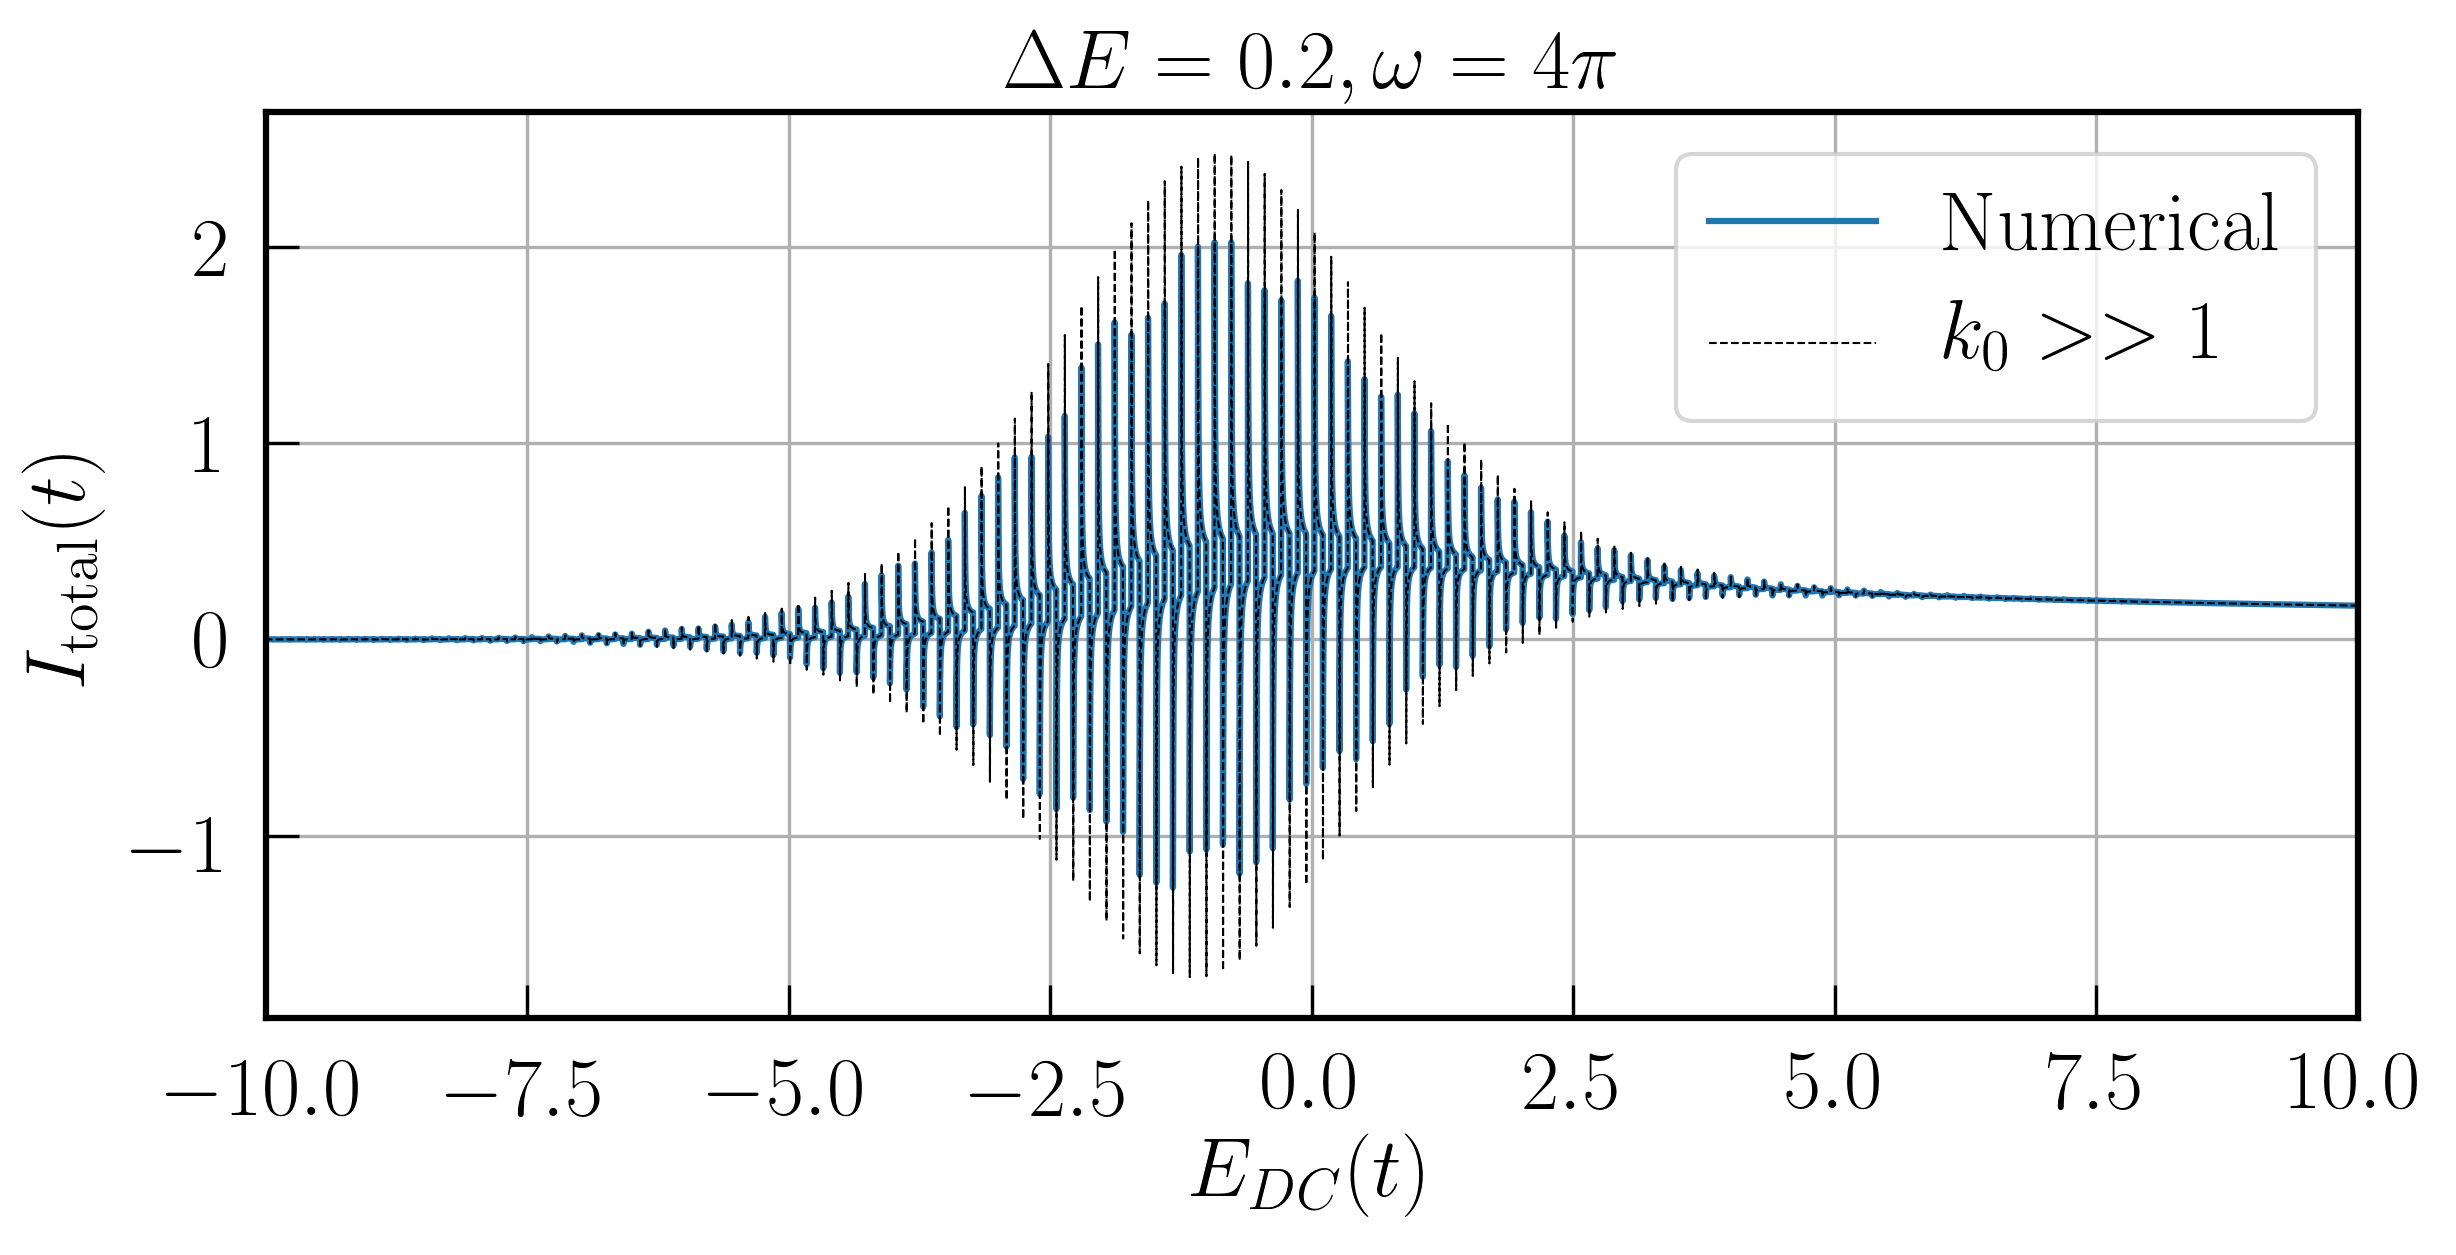

In [183]:
pl.plot(E_linear(t), I, label = 'Numerical')
pl.plot(E_linear(t_integral), I_integral, 'k--', lw = 0.5, label = r'$k_0>>1$')

pl.xlabel(r'$E_{DC}(t)$')
pl.ylabel(r'$I_{\mathrm{total}}(t)$')
pl.title(r'$\Delta E = 0.2, \omega = 4\pi$')
pl.xlim(-10, 10)
pl.grid()
pl.legend()
pl.savefig('SWV.png', bbox_inches = 'tight')

In [222]:
I_hat = np.fft.fft(I)
# Sampling Frequency(we take 1000 measurements per second):
fs = 1000
freqs = np.fft.fftfreq(t_final * fs + 1) * fs

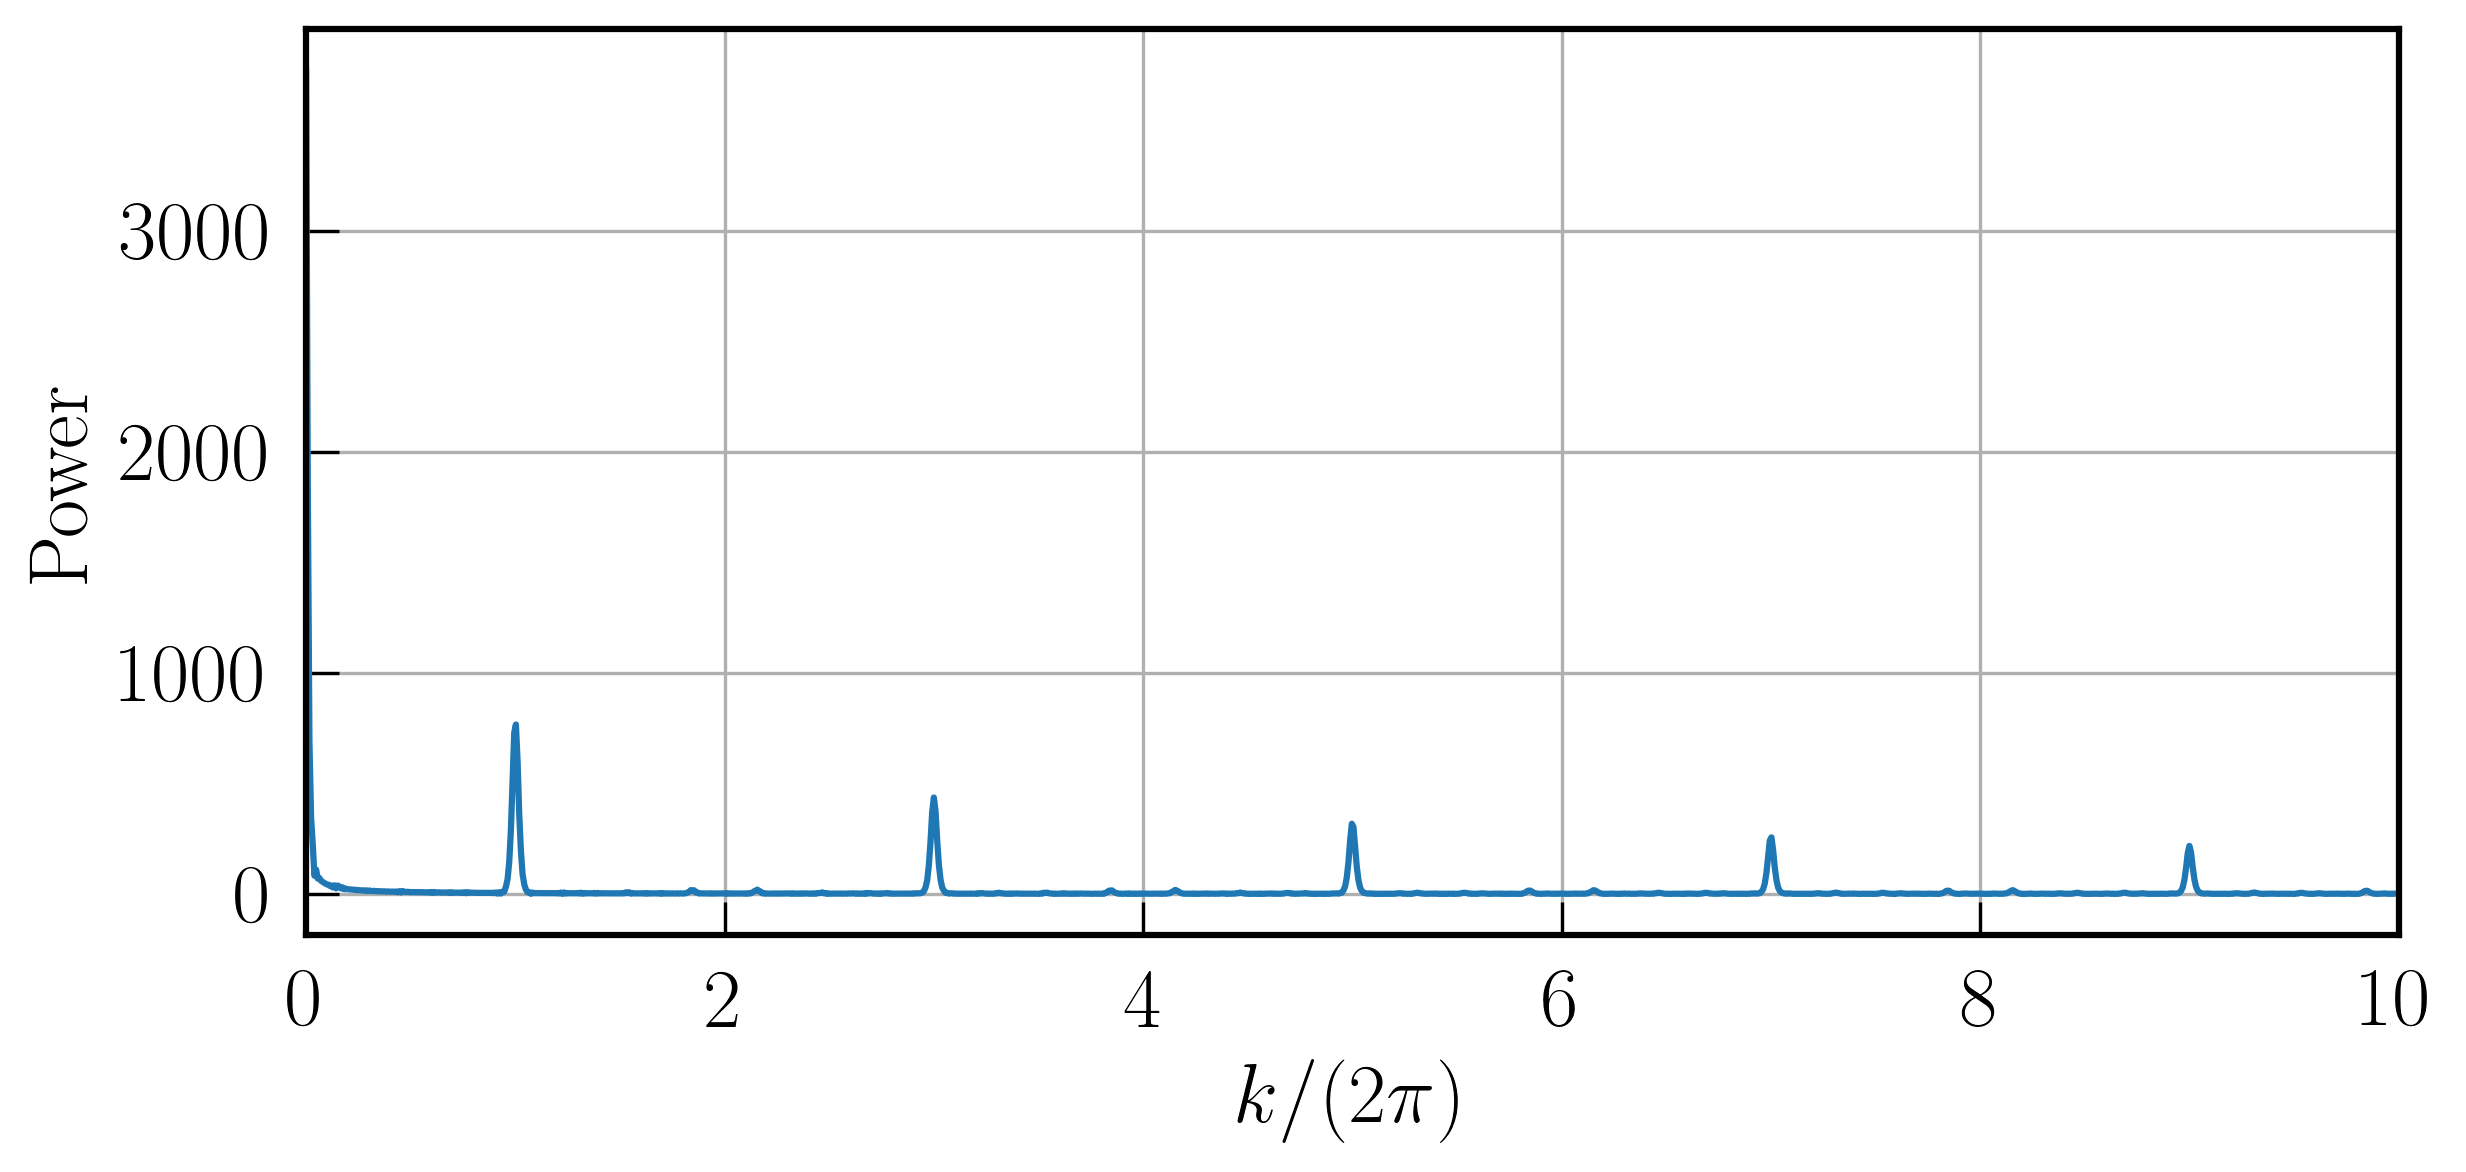

In [184]:
pl.plot(freqs[:10000]/(2*np.pi), abs(I_hat)[:10000])
pl.xlim(0, 10)
pl.ylabel('Power')
pl.xlabel(r'$k/(2\pi)$')
pl.grid()
pl.savefig('SWV_power.png', bbox_inches = 'tight')

In [223]:
I_hat1 = np.fft.fft(I1)
I_hat4 = np.fft.fft(I4)
I_hat8 = np.fft.fft(I8)

In [291]:
def get_DC(I_hat):
    I_hat = I_hat * np.exp(-5 * freqs**2)
    return np.fft.ifft(I_hat).real

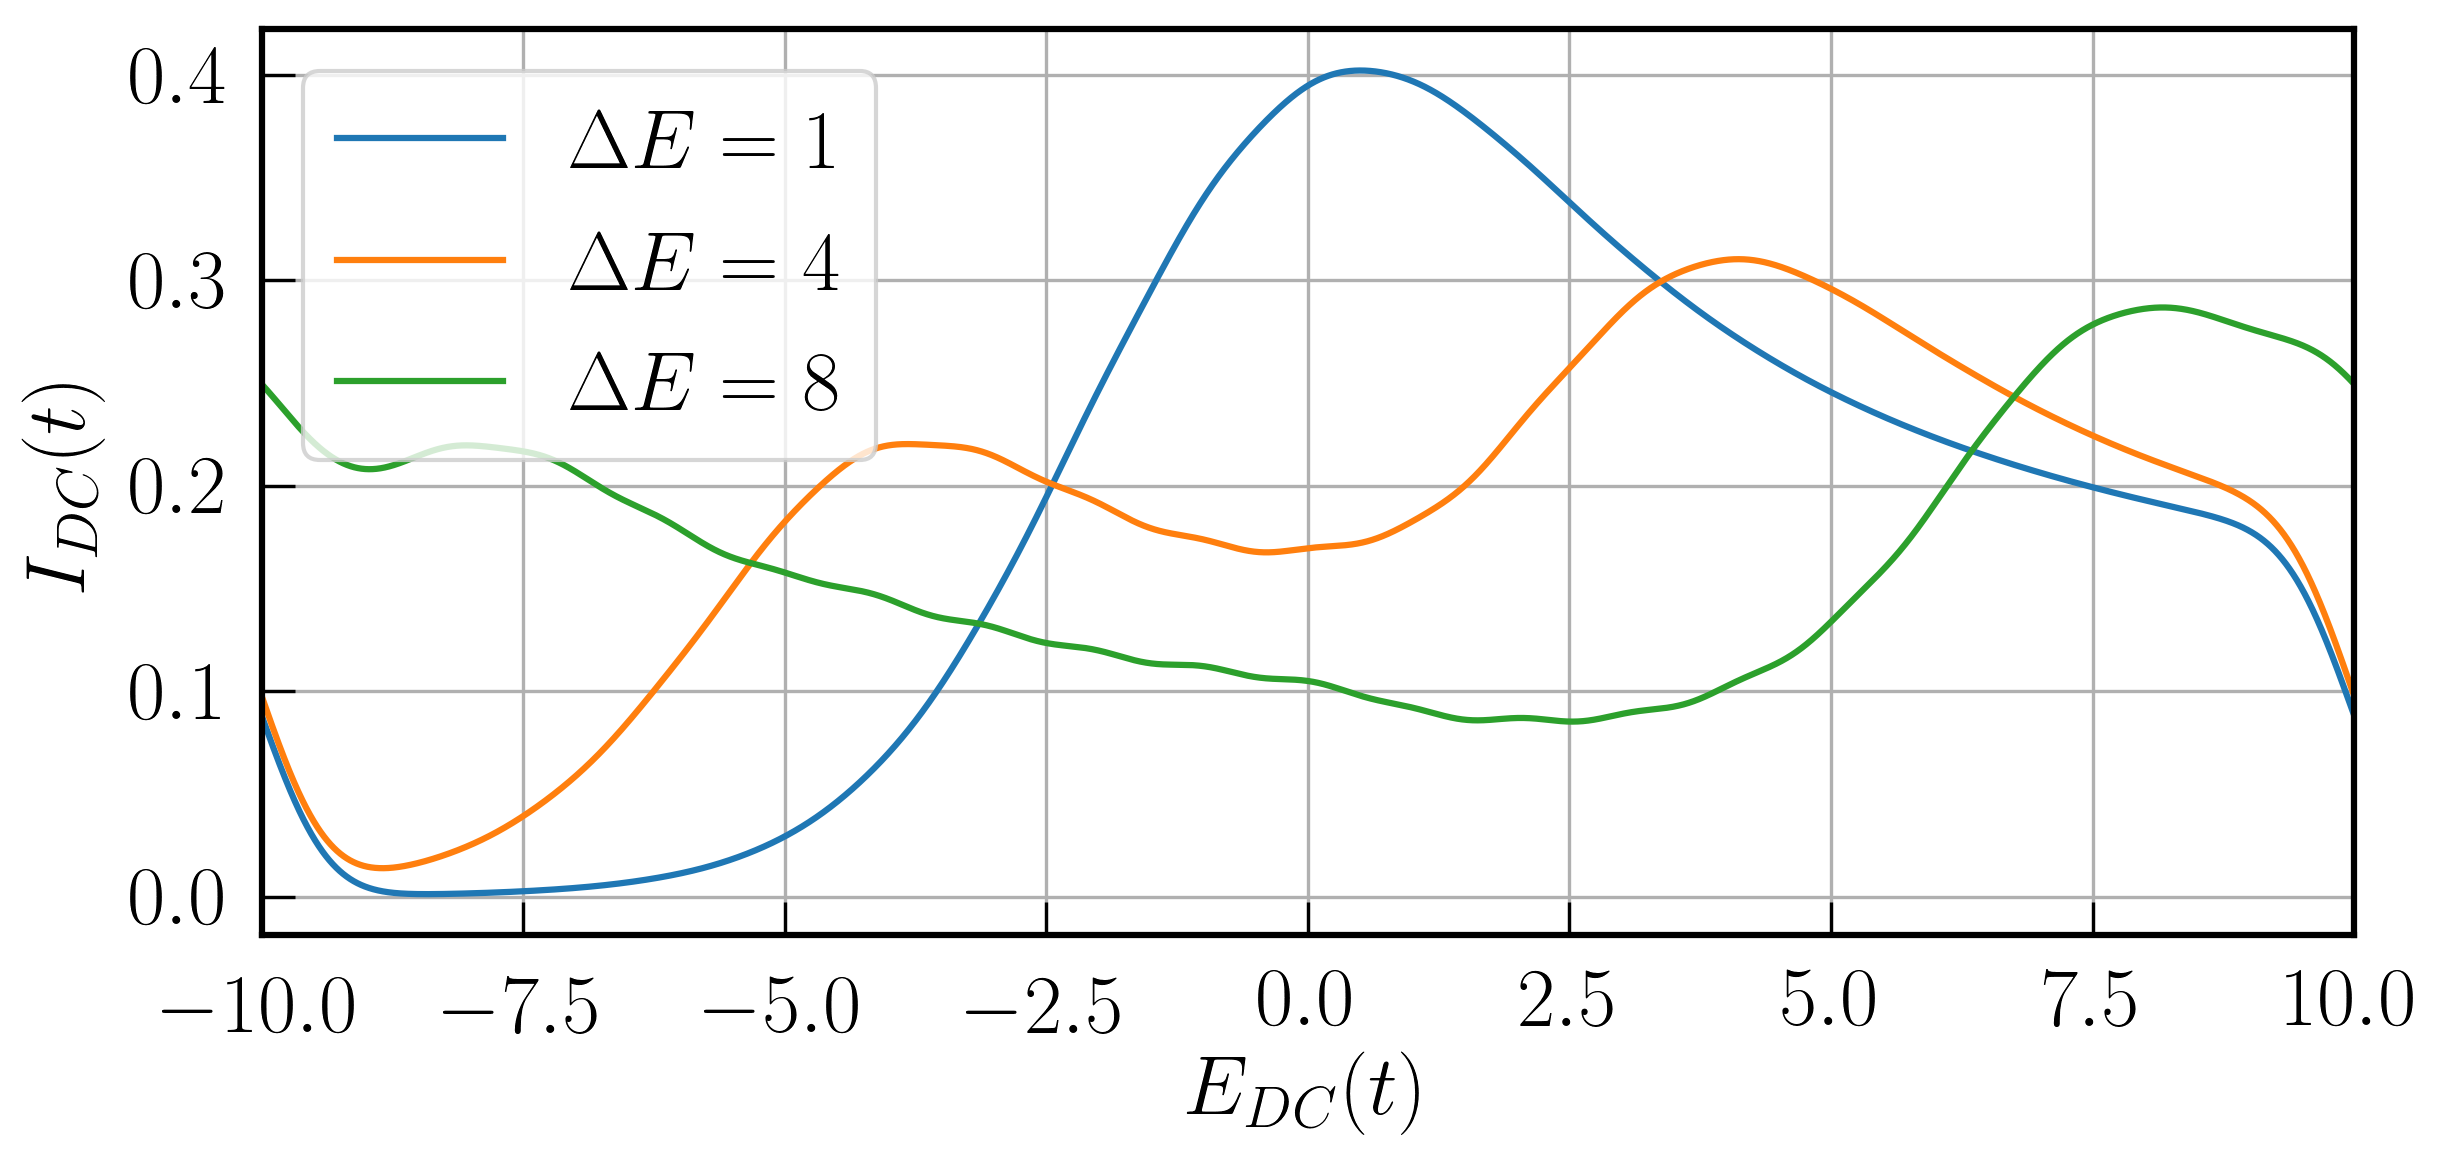

In [299]:
pl.plot(E_linear(t), get_DC(I_hat1), label = r'$\Delta E = 1$')
pl.plot(E_linear(t), get_DC(I_hat4), label = r'$\Delta E = 4$')
pl.plot(E_linear(t), get_DC(I_hat8), label = r'$\Delta E = 8$')
pl.xlabel(r'$E_{DC}(t)$')
pl.ylabel(r'$I_{DC}(t)$')
# pl.title(r'$\omega = 4\pi$')
pl.xlim(-10, 10)
pl.grid()
pl.legend()
pl.savefig('SWV2.png', bbox_inches = 'tight')